In [1]:
#indir = "/data/Mito_Trace/output/annotation_clones/data/cd34norm/MTblacklist/DE_large"
indir = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_large/minPct_0__logThresh_0"

se_indir = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_large"
n_donors = 4
cdf_thresh = 0.3

n_top_genes = 5
n_top_clones = 3
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"


fdr.thresh=0.1

In [2]:
source(utils_script)

Attaching SeuratObject



In [3]:
outdir <- paste0(indir, "/", "cdf_thresh__", (cdf_thresh))
#dir.create(outdir)

In [4]:
library(Seurat)
library(Signac)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
library("ComplexHeatmap")
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




Loading required package: B

## Import seurat object

In [5]:
se <- readRDS(file.path(se_indir, "se.clonesfilt.rds"))
init.large.clones <- read.csv(file.path(se_indir, "large_clones.csv"))
#large.clones <- init.large.clones %>% filter(cdf.norm<cdf_thresh)
#large.clones <- check.if.one.clone(large.clones, init.large.clones, n_top_clones)


large.clones = dplyr::bind_rows(lapply(0:(n_donors-1), 
                                       FUN=get.top.clones, clones=init.large.clones, 
                                       cdf_thresh=cdf_thresh, n_top_clones=n_top_clones))
large.clones

[1] "cdf thresh clones"
[1] 1 9


Warning message in if (dim(cdf.clones[1]) > n_top_clones) {:
“the condition has length > 1 and only the first element will be used”


[1] "cdf thresh clones"
[1] 3 9


Warning message in if (dim(cdf.clones[1]) > n_top_clones) {:
“the condition has length > 1 and only the first element will be used”


[1] "cdf thresh clones"
[1] 3 9


Warning message in if (dim(cdf.clones[1]) > n_top_clones) {:
“the condition has length > 1 and only the first element will be used”


[1] "cdf thresh clones"
[1] 2 9


Warning message in if (dim(cdf.clones[1]) > n_top_clones) {:
“the condition has length > 1 and only the first element will be used”


X,donor,lineage,norm.total,total,name,cdf.norm,cdf,index
<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>
1,0,54,0.3700399,590,0_54,0.18501994,590,1
2,0,0,0.2796493,460,0_0,0.32484458,1050,2
3,0,2,0.1345464,229,0_2,0.39211776,1279,3
5,1,1,0.1352577,209,1_1,0.06762887,209,1
6,1,0,0.1328909,207,1_0,0.13407432,416,2
7,1,2,0.1303944,189,1_2,0.19927152,605,3
14,2,1,0.1397429,154,2_1,0.06987147,154,1
15,2,0,0.1323743,169,2_0,0.13605860,323,2
16,2,3,0.1248160,150,2_3,0.19846660,473,3


In [6]:
se <- subset(se, subset= name %in% factor(large.clones$name))

In [7]:
Idents(se) <- "name"

## TF DE

## Summarize results

In [8]:
motifs.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
#colnames(motifs.pvals) <- large.clones$name
#motifs.pvals[,] = 1

all.names.sig <- c()
#motif.pvals = data.frame()
DefaultAssay(se) <- "chromvarnames"
for (d in 0:(n_donors-1)){
    print('donor')
    print(d)
    curr.indir <- file.path(indir, paste0("donor", d, "_TF"))

    donor.large.clones <- large.clones %>% filter(donor==d)
    if (dim(donor.large.clones)[1] < 2){
        print('no donor')
        next
    }
    clones.filt.ids <- sort(donor.large.clones$lineage)
    se.filt <- subset(se, subset = (donor==d) & (lineage %in% donor.large.clones$lineage))
    if (length(clones.filt.ids) < 2){
        print("0 or 1 clone found. not running")
        next
    }
    pairs = combn(clones.filt.ids,2)
    names.sig <- c()

    for (i in 1:dim(pairs)[2]){
        try({
        print(pairs[,i])
        print(paste("comparison #", i))
        a = pairs[1,i]
        b = pairs[2,i]
        curr.tf.da <- read.csv(file.path(curr.indir, 
                                         paste0("clones_",a,"__", b,".DE.TF.csv"))) %>% 
                      arrange(p_val)
        print(head(curr.tf.da))
        row.names(curr.tf.da) <- curr.tf.da$X  #sapply(curr.tf.da$X, function(m) {motifs@motif.names[[m]]})
        #curr.tf.da
        
        curr.sig <- curr.tf.da %>% filter(p_val_adj_BH<0.1)
        if (dim(curr.sig)[1]==0){
            curr.sig <- head(curr.tf.da[order(curr.tf.da$p_val),],3)
        }
        print('curr significant motifs')
        print(dim(curr.sig))
        motifs.pvals[row.names(curr.sig),paste("d", d,"_a",a,"_b", b)] <- curr.sig$p_val_adj_BH
        #motif.pvals = c(motif.pvals, curr.sig$p_val_adj_BH)
        curr.names <- row.names(curr.sig)
        names.sig <- c(names.sig, curr.names)# head(row.names(curr.tf.da), n_top_genes))
        all.names.sig <- c(all.names.sig, curr.names) #head(row.names(curr.tf.da), n_top_genes))
        DefaultAssay(se.filt) <- "ATAC"
        raw.ids <- names(Motifs(se.filt)@motif.names)
        rownames(curr.tf.da) <- sapply((curr.tf.da$X), function(x){raw.ids[match(x, Motifs(se.filt)@motif.names)]})
        })
    }
    DefaultAssay(se.filt) <- "chromvarnames"
    }
all.names.sig <- unique(all.names.sig)

[1] "donor"
[1] 0
[1] 0 2
[1] "comparison # 1"
             X        p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1        HOXB7 0.0003337197  0.2949093 0.541 0.397 0.2112446     0.176855
2       SREBF2 0.0006136906 -0.2647812 0.402 0.533 0.3884662     0.176855
3        SCRT2 0.0008748025  0.2661061 0.548 0.441 0.5537500     0.176855
4        HOXA6 0.0011345806  0.2933891 0.507 0.406 0.7181895     0.176855
5        CTCFL 0.0014910721  0.2323689 0.563 0.410 0.9438486     0.176855
6 STAT1::STAT2 0.0016763503 -0.3799203 0.370 0.515 1.0000000     0.176855
[1] "curr significant motifs"
[1] 3 7
[1]  0 54
[1] "comparison # 2"
          X        p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1    SREBF2 0.0003717654 -0.2137176 0.402 0.505 0.2353275    0.2353275
2     ESRRB 0.0014815989 -0.1759607 0.428 0.525 0.9378521    0.4598468
3   ZKSCAN5 0.0021793690 -0.2204718 0.380 0.461 1.0000000    0.4598468
4 JUN::JUNB 0.0031069713 -0.2132240 0.330 0.369 1.0000000    0.4843714
5    SREBF1

In [9]:
#motifs.pvals[is.na(motifs.pvals)] <- 1
motifs.pvals

#motifs.pvals <- -log10(motifs.pvals)

,d 0 _a 0 _b 2,d 0 _a 0 _b 54,d 0 _a 2 _b 54,d 1 _a 0 _b 1,d 1 _a 0 _b 2,d 1 _a 1 _b 2,d 2 _a 0 _b 1,d 2 _a 0 _b 3,d 2 _a 1 _b 3,d 3 _a 0 _b 1,d 3 _a 0 _b 2,d 3 _a 1 _b 2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOXF2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
FOXD1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
IRF2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MZF1(var.2),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAX::MYC,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PPARG,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PAX6,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
PBX1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RORA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [10]:
sig.motifs.ordered <- sort(rowMeans(-log10(motifs.pvals),na.rm=T), decreasing=T)
sig.motifs.ordered

TEF          HOXB7          SCRT2         SREBF2          FOSL2 
   1.052097937    0.752382757    0.752382757    0.690355066    0.681098766 
         BACH1            EHF          CEBPA         ZBTB7B          CTCFL 
   0.681098766    0.629880337    0.560938577    0.533545770    0.531939155 
         CEBPD           ELF3          GABPA            EN1           PDX1 
   0.452709063    0.427227647    0.427227647    0.398353474    0.398353474 
         HOXA2         PHOX2B        ZKSCAN5           KLF2          ESRRB 
   0.398353474    0.396619700    0.395047924    0.376501351    0.337386785 
BHLHE22(var.2)   MEIS1(var.2)         ZNF341           ZIC1          FOXC2 
   0.062833376    0.062833376    0.062833376    0.043948420    0.043948420 
          ETV1           RARA           TP63          KLF13   NR2F6(var.3) 
   0.043948420    0.011799688    0.011799688    0.004927027    0.004927027 
        NKX2-2 
   0.004927027

## Dotplot for all donors

In [11]:
DefaultAssay(se) <- "chromvarnames"

In [12]:
se.avg = AverageExpression(se, assays = "chromvarnames", group.by = "name", features = all.names.sig)$chromvarnames 
se.avg

,0_0,0_2,0_54,1_0,1_1,1_2,2_0,2_1,2_3,3_0,3_1,3_2
HOXB7,8.035791e-01,0.1993188,0.7975365,0.6217802,0.7113204,0.5550425,0.55129782,1.01028690,1.1521855,0.7094389,0.5790730,0.56407973
SREBF2,3.210376e-01,0.8162122,0.6386517,0.7176834,0.8106515,0.6306237,0.52868794,0.51605301,0.5751158,0.6399504,0.6698777,0.55609758
SCRT2,8.176728e-01,0.3588854,0.7293436,0.5419560,0.5090625,0.6921089,0.75754986,0.74742990,0.4809619,0.6091891,0.6084888,0.56439256
ESRRB,3.843906e-01,0.6940440,0.6072746,0.6027127,0.7192516,0.5363585,0.26916281,0.44434143,0.3151670,0.3159355,0.4592871,0.38083057
ZKSCAN5,1.263866e+00,2.1869535,2.1662584,1.7550816,0.9025418,0.5588283,-0.09481993,-0.12088875,0.6141704,1.9332298,2.4522188,2.12723353
TEF,1.448077e+00,0.8240212,1.1978669,0.6001742,1.9159376,1.2640003,0.24932447,0.84266808,0.8615356,1.3484477,0.8087832,0.96405975
CEBPA,7.285127e+00,4.1147433,4.4405251,2.0142200,5.8050496,3.6425002,0.46291683,1.40345117,0.5826926,4.3479122,3.4916424,3.79595252
CEBPD,6.526294e+00,4.3014918,6.0395734,2.7240768,6.6868899,4.4100450,0.42036513,1.98832482,1.0469810,6.0218071,3.0976001,3.93073032
MEIS1(var.2),4.361609e-01,0.2711949,0.8677065,0.9113778,0.5553342,0.3433617,1.09508162,0.80041147,1.6103791,0.6323783,0.8150441,0.56836626
BHLHE22(var.2),5.147440e-01,0.4507387,0.8851634,0.6714408,0.4915452,0.2222494,0.57615627,0.64747273,0.4882117,0.6050965,0.9190678,0.54972573


In [13]:
se.avg.order <- se.avg[names(sig.motifs.ordered[names(sig.motifs.ordered) %in% all.names.sig]),]
se.avg.order

,0_0,0_2,0_54,1_0,1_1,1_2,2_0,2_1,2_3,3_0,3_1,3_2
TEF,1.448077e+00,0.8240212,1.1978669,0.6001742,1.9159376,1.2640003,0.24932447,0.84266808,0.8615356,1.3484477,0.8087832,0.96405975
HOXB7,8.035791e-01,0.1993188,0.7975365,0.6217802,0.7113204,0.5550425,0.55129782,1.01028690,1.1521855,0.7094389,0.5790730,0.56407973
SCRT2,8.176728e-01,0.3588854,0.7293436,0.5419560,0.5090625,0.6921089,0.75754986,0.74742990,0.4809619,0.6091891,0.6084888,0.56439256
SREBF2,3.210376e-01,0.8162122,0.6386517,0.7176834,0.8106515,0.6306237,0.52868794,0.51605301,0.5751158,0.6399504,0.6698777,0.55609758
FOSL2,2.700482e+04,7.5288224,30.5825882,30.7256453,58.2802034,114.6166874,23.81464781,10.48470938,36.0489207,272.4804447,94.3267535,6.30339568
BACH1,6.095546e+01,2.5171453,2.1524500,6.9854701,6.1911843,19.7007134,2.78446561,7.62134784,7.8622439,5.0129713,3.6114980,1.81740089
EHF,1.945089e+00,3.6587354,3.3483275,3.0241550,1.8613781,1.9591766,-0.10791109,-0.36020760,0.7478584,2.5118123,2.2734913,2.91906656
CEBPA,7.285127e+00,4.1147433,4.4405251,2.0142200,5.8050496,3.6425002,0.46291683,1.40345117,0.5826926,4.3479122,3.4916424,3.79595252
ZBTB7B,6.053653e-01,0.4807172,0.6501554,0.6925168,0.8927097,0.2046083,0.78907212,0.83486356,0.6903093,0.5937516,0.7765128,0.54180018
CTCFL,9.169377e-01,0.3840258,0.7298778,1.0421938,0.7467923,0.2018137,1.11885140,1.09321384,0.7839975,0.4431296,0.5620435,0.20270042


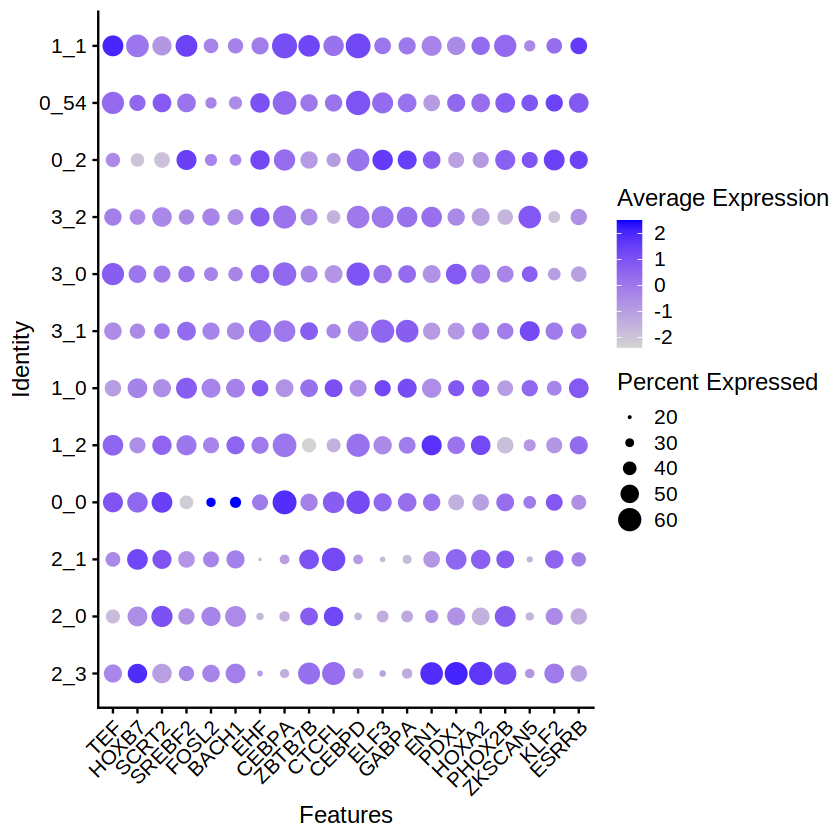

In [14]:
#pdf(file = file.path(outdir, "dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = head(names(sig.motifs.ordered),20), group.by="name", cluster.idents=T) + RotatedAxis()
dot

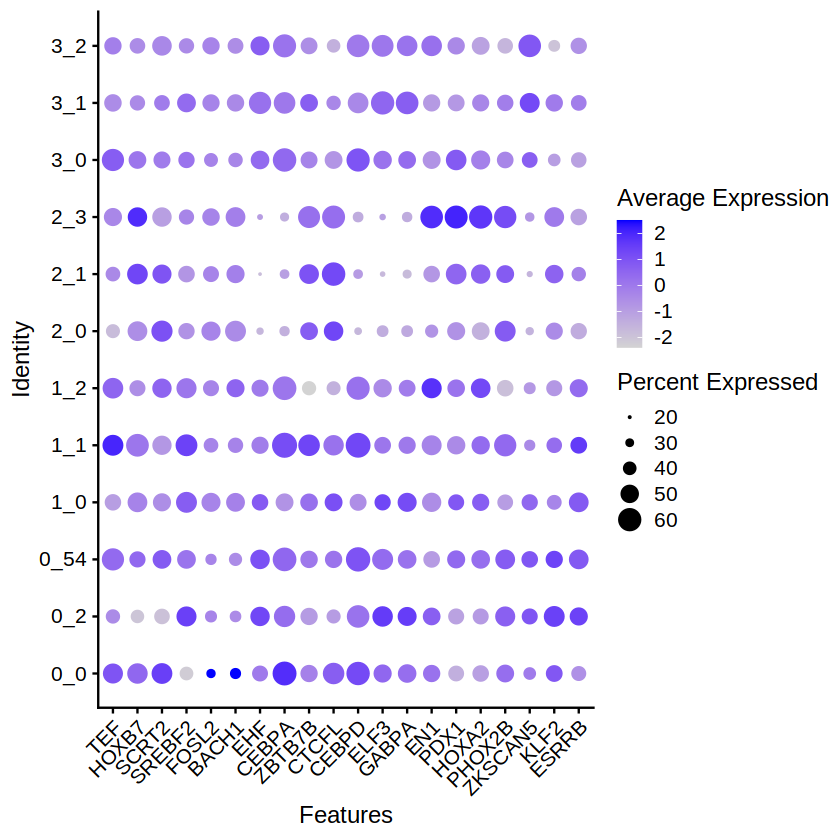

In [15]:
#pdf(file = file.path(outdir, "dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = head(names(sig.motifs.ordered),20), group.by="name", cluster.idents=F) + RotatedAxis()
dot
ggsave(file = file.path(outdir, "dotplot.allDonors.clones.topPvals.pdf"), width = 16, height = 16)


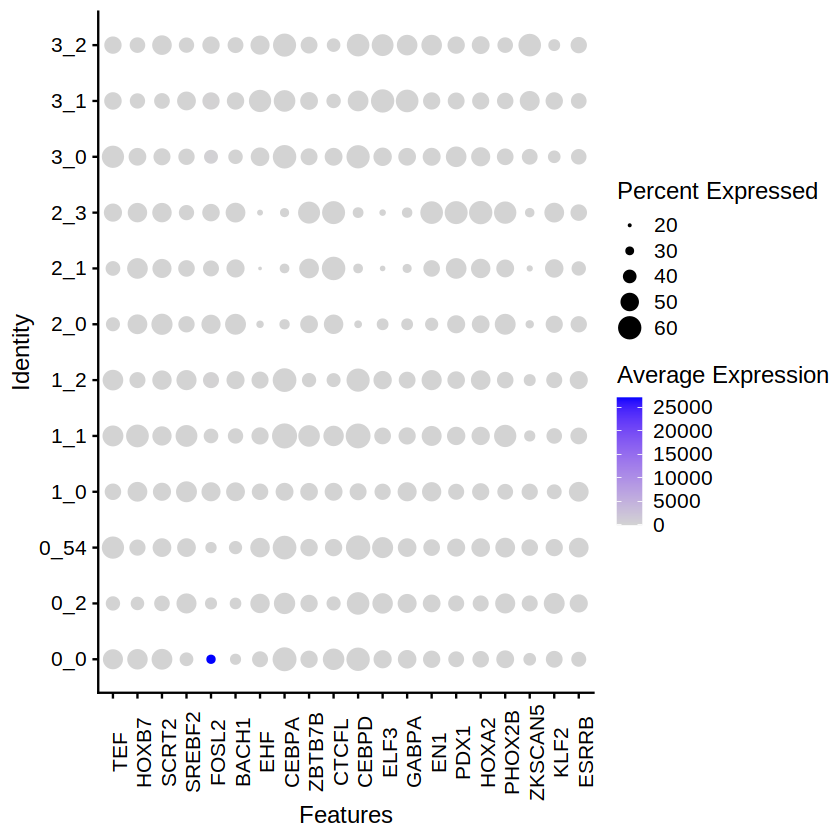

In [16]:
# very add-hoc solution
# ideas from mnel's post in https://stackoverflow.com/questions/13407236/remove-a-layer-from-a-ggplot2-chart

library(ggplot2)
#varFeat <- c("LYZ", "CCL5", "IL32", "PTPRCAP", "FCGR3A", "PF4")
g <- DotPlot(object = se, features = head(names(sig.motifs.ordered),20), assay="chromvarnames")

g$layers[[1]] <- NULL # remove original geom_point layer where the color scale is hard-coded to use scaled average expression
g <- g + 
    geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp')) +
    guides(color = guide_colorbar(title = 'Average Expression')) + 
    theme(axis.text.x = element_text(angle=90))

plot(g)

ggsave(file = file.path(outdir, "dotplot.allDonors.clones.topPvals.noZ.pdf"), width = 16, height = 16)


In [17]:
se.avg.order <- data.frame(se.avg.order)
se.avg.order[,"avg_pval_adj_-log10"] = sig.motifs.ordered
se.avg.order

,X0_0,X0_2,X0_54,X1_0,X1_1,X1_2,X2_0,X2_1,X2_3,X3_0,X3_1,X3_2,avg_pval_adj_-log10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TEF,1.448077e+00,0.8240212,1.1978669,0.6001742,1.9159376,1.2640003,0.24932447,0.84266808,0.8615356,1.3484477,0.8087832,0.96405975,1.052097937
HOXB7,8.035791e-01,0.1993188,0.7975365,0.6217802,0.7113204,0.5550425,0.55129782,1.01028690,1.1521855,0.7094389,0.5790730,0.56407973,0.752382757
SCRT2,8.176728e-01,0.3588854,0.7293436,0.5419560,0.5090625,0.6921089,0.75754986,0.74742990,0.4809619,0.6091891,0.6084888,0.56439256,0.752382757
SREBF2,3.210376e-01,0.8162122,0.6386517,0.7176834,0.8106515,0.6306237,0.52868794,0.51605301,0.5751158,0.6399504,0.6698777,0.55609758,0.690355066
FOSL2,2.700482e+04,7.5288224,30.5825882,30.7256453,58.2802034,114.6166874,23.81464781,10.48470938,36.0489207,272.4804447,94.3267535,6.30339568,0.681098766
BACH1,6.095546e+01,2.5171453,2.1524500,6.9854701,6.1911843,19.7007134,2.78446561,7.62134784,7.8622439,5.0129713,3.6114980,1.81740089,0.681098766
EHF,1.945089e+00,3.6587354,3.3483275,3.0241550,1.8613781,1.9591766,-0.10791109,-0.36020760,0.7478584,2.5118123,2.2734913,2.91906656,0.629880337
CEBPA,7.285127e+00,4.1147433,4.4405251,2.0142200,5.8050496,3.6425002,0.46291683,1.40345117,0.5826926,4.3479122,3.4916424,3.79595252,0.560938577
ZBTB7B,6.053653e-01,0.4807172,0.6501554,0.6925168,0.8927097,0.2046083,0.78907212,0.83486356,0.6903093,0.5937516,0.7765128,0.54180018,0.533545770


In [18]:
write.csv(se.avg.order, 
          file=file.path(outdir, "clone.TFactivity.topPvals.txt"), quote=F)
se.avg.order

,X0_0,X0_2,X0_54,X1_0,X1_1,X1_2,X2_0,X2_1,X2_3,X3_0,X3_1,X3_2,avg_pval_adj_-log10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TEF,1.448077e+00,0.8240212,1.1978669,0.6001742,1.9159376,1.2640003,0.24932447,0.84266808,0.8615356,1.3484477,0.8087832,0.96405975,1.052097937
HOXB7,8.035791e-01,0.1993188,0.7975365,0.6217802,0.7113204,0.5550425,0.55129782,1.01028690,1.1521855,0.7094389,0.5790730,0.56407973,0.752382757
SCRT2,8.176728e-01,0.3588854,0.7293436,0.5419560,0.5090625,0.6921089,0.75754986,0.74742990,0.4809619,0.6091891,0.6084888,0.56439256,0.752382757
SREBF2,3.210376e-01,0.8162122,0.6386517,0.7176834,0.8106515,0.6306237,0.52868794,0.51605301,0.5751158,0.6399504,0.6698777,0.55609758,0.690355066
FOSL2,2.700482e+04,7.5288224,30.5825882,30.7256453,58.2802034,114.6166874,23.81464781,10.48470938,36.0489207,272.4804447,94.3267535,6.30339568,0.681098766
BACH1,6.095546e+01,2.5171453,2.1524500,6.9854701,6.1911843,19.7007134,2.78446561,7.62134784,7.8622439,5.0129713,3.6114980,1.81740089,0.681098766
EHF,1.945089e+00,3.6587354,3.3483275,3.0241550,1.8613781,1.9591766,-0.10791109,-0.36020760,0.7478584,2.5118123,2.2734913,2.91906656,0.629880337
CEBPA,7.285127e+00,4.1147433,4.4405251,2.0142200,5.8050496,3.6425002,0.46291683,1.40345117,0.5826926,4.3479122,3.4916424,3.79595252,0.560938577
ZBTB7B,6.053653e-01,0.4807172,0.6501554,0.6925168,0.8927097,0.2046083,0.78907212,0.83486356,0.6903093,0.5937516,0.7765128,0.54180018,0.533545770


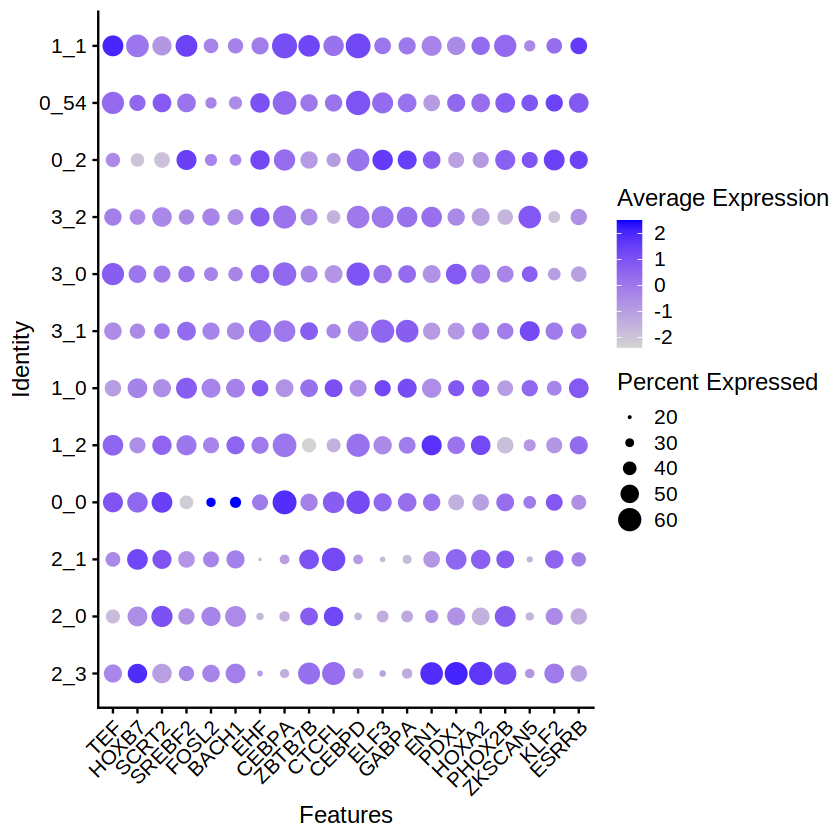

In [19]:
#pdf(file = file.path(outdir, "dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = head(names(sig.motifs.ordered),20), group.by="name", cluster.idents=T) + RotatedAxis()
dot